* **Company:** Alber Blanc
* **Author:** Hakob Petrosyan
* **Phone:** +79309878934
* **Adress:** MIPT, Moscow
* **Contacts:** akob.petrosyan@phystech.edu, [vk.com/jacpetro](vk.com/jacpetro), [https://t.me/jacpetro](https://t.me/jacpetro).

![](AlberBlanc.jpg)

# Сравнение разных вариантов подключения

Гипотеза, поставленная в `analyze.ipynb`, о том что, статистические отличия в распределениях по большей части зависят от метода подключения оказалось верной. В подтверждение этой гипотезы, выполним следующие варианты подключений и визуально сравним отличия:

1. [MWMT - multiple sockets multiple threads (Deafult variant)] Создадим 5 синхронных вебсокетов с помощью библиотеки `websocket-client` и каждому из них отдатим на управление стандартному потоку из `threading`.
2. [MWST - multiple sockets single thread] Так как библиотека `websocket-client` не умеет создавать асинхронные киленты, создадим 5 асинхронных вебсокетов с помощью библиотеки `python-binnace`, а именно через `binance.BinanceSocketManager`, который принимает на вход экземпляр класса `binance.AsyncClient`. Каждый сокет будет управляться своей корутиной-задачей. В результате будет один поток и 5 асинхронных вебсокетов.
3. [SWST - single socket single thread] Создадим 1 асинхронный сокет, через который подпишемся на несколько одинаковых стримов. Будем использовать нативный `binance api` в паре с `websockets`, который умеет создавать асинхронные сокеты. Мы намеренно не будем использовать `BinanceSocketManager.multiplex_socket`, так как он не возвращает `timestamp` сервера. А так же не будем использовать `combined` режим для стрима, так как из=за одинаковых названий и идентификаторов становиться невозможно отличать ответы корутин (или я не нашел как это грамотно сделать). В результате просто сделаем 5 подписок с разными идентификаторами, благо `binance api` позволяет до 200 параллельных подписок.

Понятно, что наверняка не совсем корректно сравнивать эти подходы, так как каждая библиотека имеет свою специфичную реализацию, которые могут повлиять на время получения и обработки запросов (например наличие каких-то блокирующих операций). Однако не надо забывать, что все так и или иначе используют обвертки вокруг `binance api`. Кроме того, результаты насколько отличаются, что эти детали можно не рассматривать.

In [3]:
# Standard modules
import os
import glob

# Third-party modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [5]:
mwmt_paths = glob.glob(os.path.join(os.getcwd(), "data", "MWMT", "*.pkl"))
mwst_paths = glob.glob(os.path.join(os.getcwd(), "data", "MWST", "*.pkl"))
swst_paths = glob.glob(os.path.join(os.getcwd(), "data", "SWST", "*.pkl"))

mwmt_dfs = [pd.read_pickle(path) for path in mwmt_paths]
mwst_dfs = [pd.read_pickle(path) for path in mwst_paths]
swst_dfs = [pd.read_pickle(path) for path in swst_paths]
mwmt_dfs[0].head()

,update_id,client_timestamps,delay
0,2851356806046,1.684272e+12,1951.0
1,2851356807356,1.684272e+12,1951.0
2,2851356808669,1.684272e+12,1952.0
3,2851356808682,1.684272e+12,1953.0
4,2851356809394,1.684272e+12,1952.0


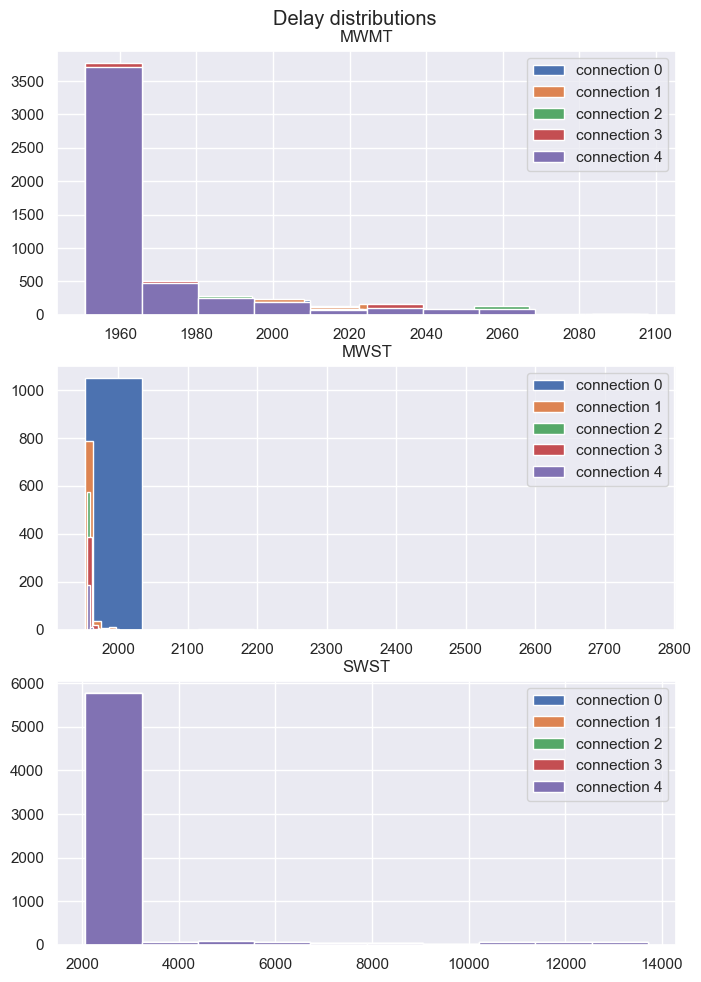

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10))
fig.suptitle("Delay distributions")
fig.tight_layout()

for j, (dfs, t) in enumerate(zip((mwmt_dfs, mwst_dfs, swst_dfs), ("MWMT", "MWST", "SWST"))):
    for i, df in enumerate(dfs):
        ax[j].hist(df.delay, bins=10, label=f"connection {i}")
        ax[j].set_title(t)
        ax[j].legend()